In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import math
from scipy.stats import norm

In [31]:
csv_file_path = "./data/round_4/prices_round_4_day_1.csv"
# csv_file_path = "./data/round_3/results.csv"
# csv_file_path = "./data/other/round_5_test.csv"
df = pd.read_csv(csv_file_path, sep=';')

products = np.unique(df['product'])

data = {}
stat = 'mid_price'

for prod in products:
    data[prod] = df[df['product'] == prod]
    

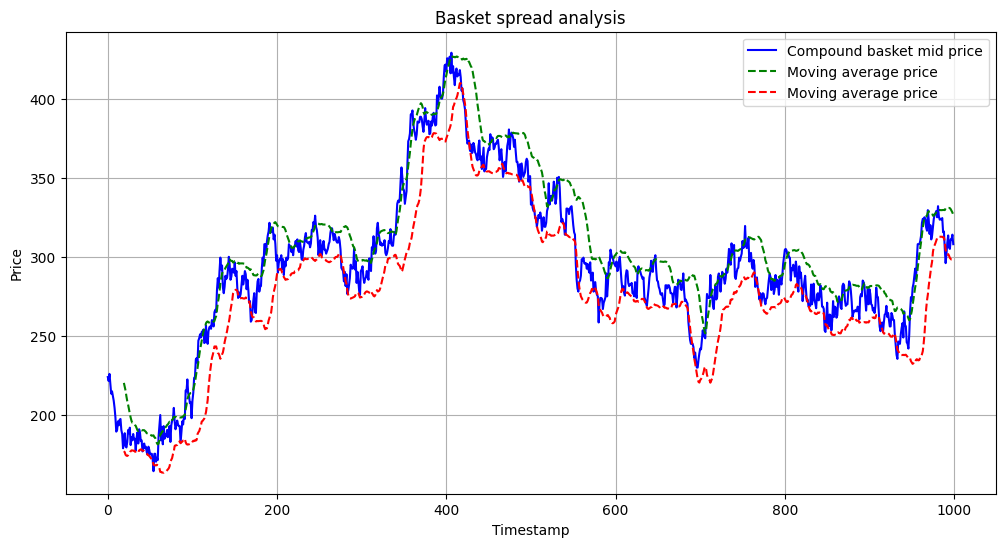

292.6655 51.67618755045693


In [225]:
# data["COMPOUND_BASKET"] = (1 * data["ROSES"][stat].values + 4 * data["CHOCOLATE"][stat].values + 6 * data["STRAWBERRIES"][stat].values)
# 
# data["BASKET_SPREAD"] = (data["GIFT_BASKET"][stat].values - data["COMPOUND_BASKET"])
# 
# window_size = 20
# moving_avg = pd.Series(data["BASKET_SPREAD"]).rolling(window=window_size).mean().dropna()
# moving_std = pd.Series(data["BASKET_SPREAD"]).rolling(window=window_size).std().dropna()
#     
# plt.figure(figsize=(12, 6))
# plt.plot(data["BASKET_SPREAD"][:], marker='', linestyle='-', color='b', label="Compound basket mid price")
# plt.plot((moving_avg + 1.25 * moving_std)[:], marker='', linestyle='--', color='g', label="Moving average price")
# plt.plot((moving_avg - 1.75 * moving_std)[:], marker='', linestyle='--', color='r', label="Moving average price")
# plt.title("Basket spread analysis")
# plt.xlabel("Timestamp")
# plt.ylabel("Price"),
# plt.legend()
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(data["GIFT_BASKET"]["profit_and_loss"].values, marker='', linestyle='-', color='b', label="Compound basket mid price")
# plt.title("Basket spread analysis")
# plt.xlabel("Timestamp")
# plt.ylabel("Price"),
# plt.legend()
# plt.grid(True)
# plt.show()


print(np.mean(data["BASKET_SPREAD"]), np.std(data["BASKET_SPREAD"]))

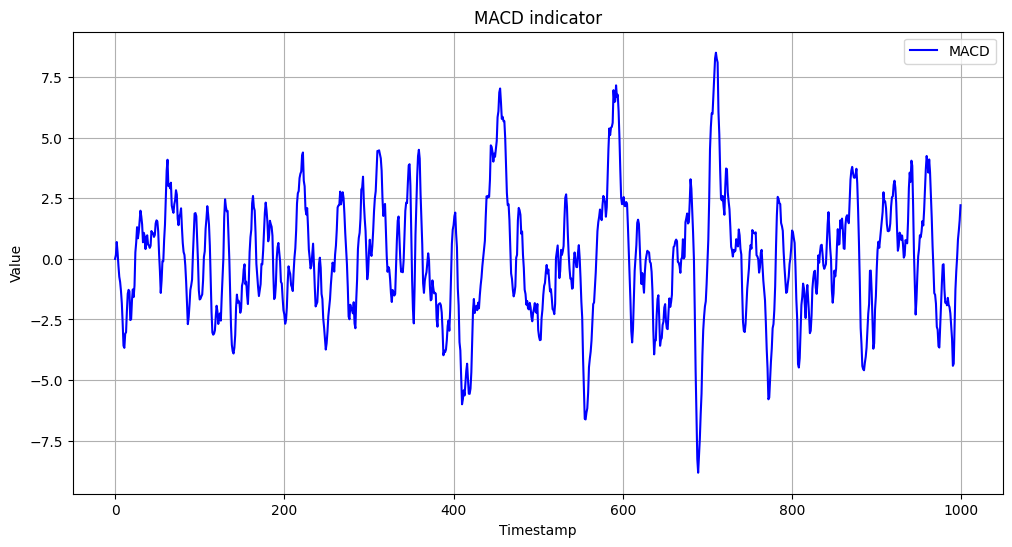

In [129]:
short_window=12
long_window=26
signal_window=9

short_ema = data["GIFT_BASKET"]["mid_price"].ewm(span=short_window, min_periods=1, adjust=False).mean()
long_ema = data["GIFT_BASKET"]["mid_price"].ewm(span=long_window, min_periods=1, adjust=False).mean()

# Calculate MACD line
macd_line = short_ema - long_ema

# Calculate signal line
signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()

# Calculate MACD histogram
macd_histogram = macd_line - signal_line

plt.figure(figsize=(12, 6))
plt.plot(macd_histogram.values, marker='', linestyle='-', color='b', label="MACD")
plt.title("MACD indicator")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

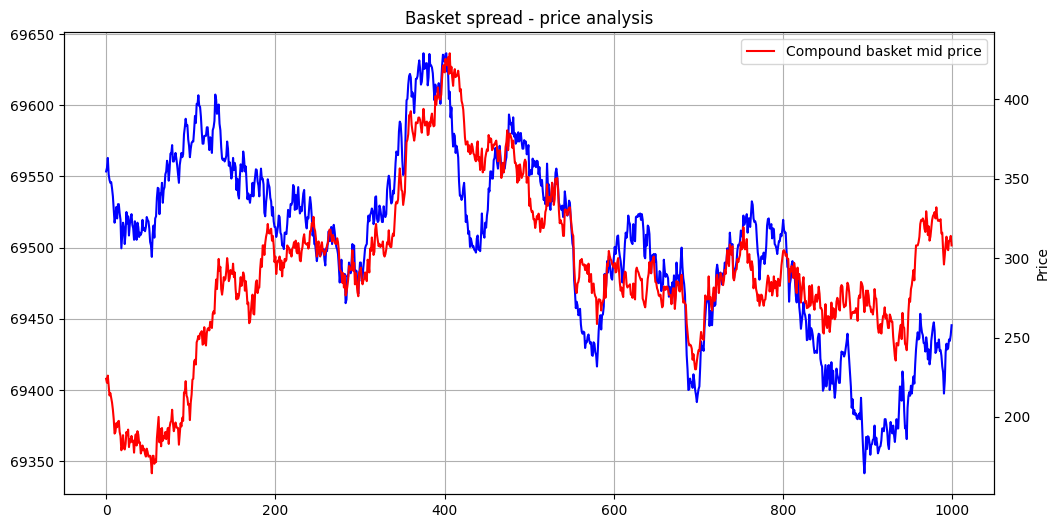

In [107]:
fig, ax1 = plt.subplots(figsize=(12,6),)
ax2 = ax1.twinx()

ax1.plot(data["GIFT_BASKET"]["mid_price"].values[:], marker='', linestyle='-', color='b', label="Real basket mid price")
ax2.plot(data["BASKET_SPREAD"][:], marker='', linestyle='-', color='r', label="Compound basket mid price")

ax1.grid(True)
# ax2.grid(True)

plt.title("Basket spread - price analysis")
plt.xlabel("Timestamp")
plt.ylabel("Price"),
plt.legend()
plt.show()

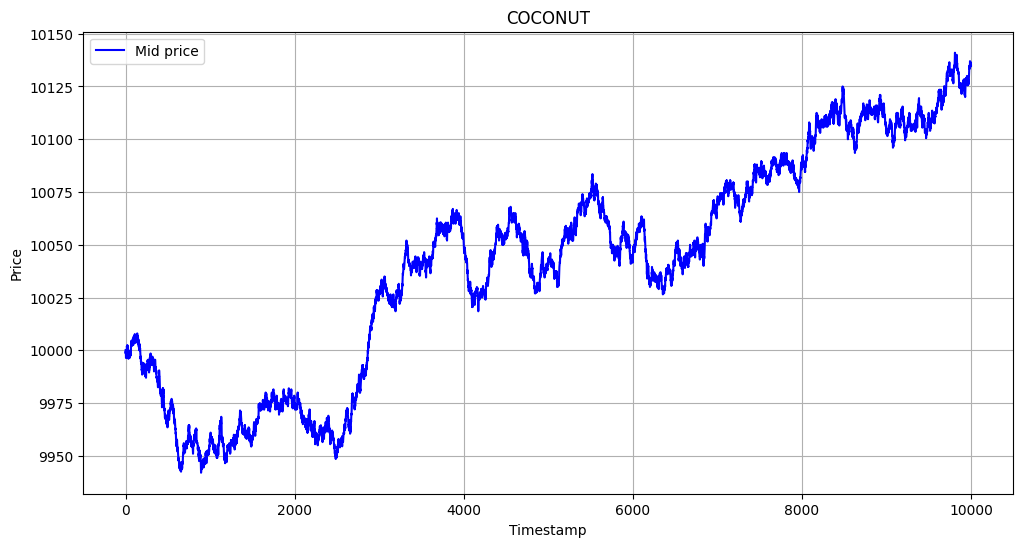

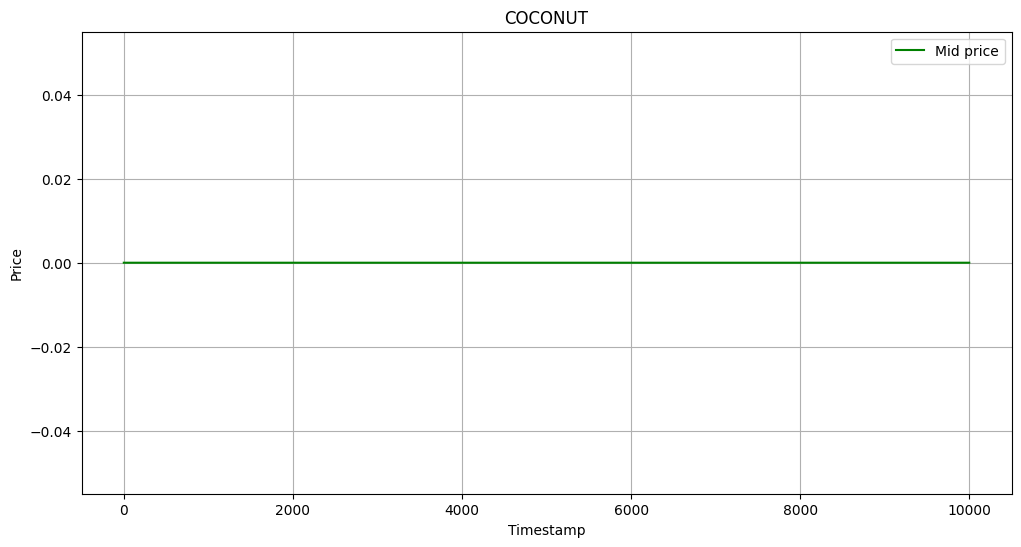

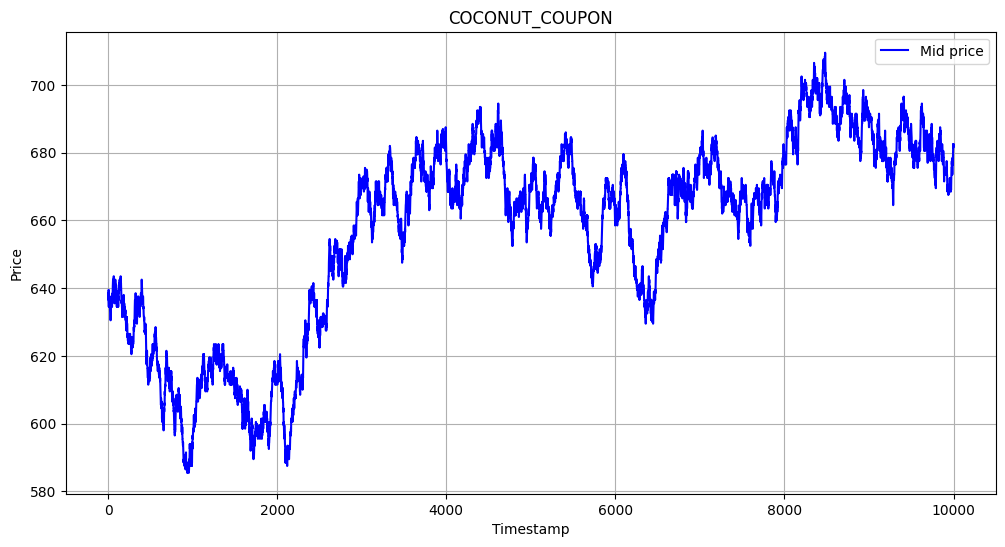

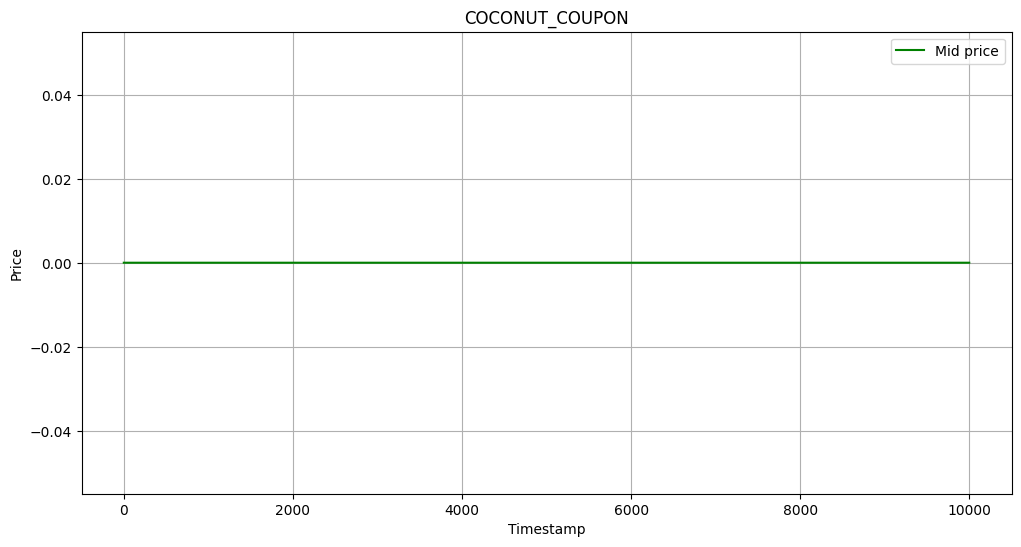

In [32]:
for prod in products:
    plt.figure(figsize=(12, 6))
    plt.plot(data[prod]["mid_price"].values[:], marker='', linestyle='-', color='b', label="Mid price")
    plt.title(prod)
    plt.xlabel("Timestamp")
    plt.ylabel("Price"),
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(data[prod]["profit_and_loss"][:].values, marker='', linestyle='-', color='g', label="Mid price")
    plt.title(prod)
    plt.xlabel("Timestamp")
    plt.ylabel("Price"),
    plt.legend()
    plt.grid(True)
    plt.show()

In [188]:
result = coint(data["GIFT_BASKET"]["mid_price"] 
               - (1 * data["ROSES"][stat].values + 4 * data["CHOCOLATE"][stat].values + 6 * data["STRAWBERRIES"][stat].values), 
               data["GIFT_BASKET"]["mid_price"] 
               - (1 * data["ROSES"][stat].values + 4 * data["CHOCOLATE"][stat].values + 6 * data["STRAWBERRIES"][stat].values))

print(result)

(-1.6799089887769816, 0.6860168557963048, array([-3.90743646, -3.34225305, -3.04869817]))


In [10]:
N_prime = norm.pdf
N = norm.cdf

def standard_normal_cdf(x):
    return 0.5 * (1 + math.erf(x / np.sqrt(2)))

def standard_normal_pdf(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)

def black_scholes_call(S, K, T, r, sigma):
    ###standard black-scholes formula
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = S * N(d1) -  N(d2)* K * np.exp(-r * T)
    return call

def vega(S, K, T, r, sigma):
    ### calculating d1 from black scholes
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))

    #see hull derivatives chapter on greeks for reference
    vega = S * N_prime(d1) * np.sqrt(T)
    return vega

def implied_volatility_call(C, S, K, T, r, tol=0.0001,
                            max_iterations=100):
    ### assigning initial volatility estimate for input in Newton_rap procedure
    sigma = 0.3
    
    for i in range(max_iterations):

        ### calculate difference between blackscholes price and market price with
        ### iteratively updated volality estimate
        diff = black_scholes_call(S, K, T, r, sigma) - C

        ###break if difference is less than specified tolerance level
        if abs(diff) < tol:
            # print(f'found on {i}th iteration')
            # print(f'difference is equal to {diff}')
            break

        ### use newton rapshon to update the estimate
        sigma = sigma - diff / vega(S, K, T, r, sigma)

    return sigma

In [27]:
# csv_file_path = "./data/round_4/prices_round_4_day_1.csv"
# csv_file_path = "./data/results/round_4.csv"
csv_file_path = "./data/other/round_5_test.csv"

df = pd.read_csv(csv_file_path, sep=';')

products = np.unique(df['product'])

data = {}
stat = 'mid_price'

for prod in products:
    data[prod] = df[df['product'] == prod]
    
volatilities = []
call_prices = []

for i in range(999):
    S = data["COCONUT"]["mid_price"].values[i]  # Current price of the underlying asset
    K = 10000  # Strike price
    T = 250 / 252    # Time to expiration (in years)
    r = 0# Risk-free interest rate
    
    if i > 0:
        if i > 50:
            volatilities.pop(0)
        sigma = np.mean(volatilities)
        call_price = black_scholes_call(S, K, T, r, sigma)
        call_prices.append(call_price)
    volatilities.append(implied_volatility_call(data["COCONUT_COUPON"]["mid_price"].values[i], S, K, T, r))

print(np.mean(volatilities))

0.1650538648670075


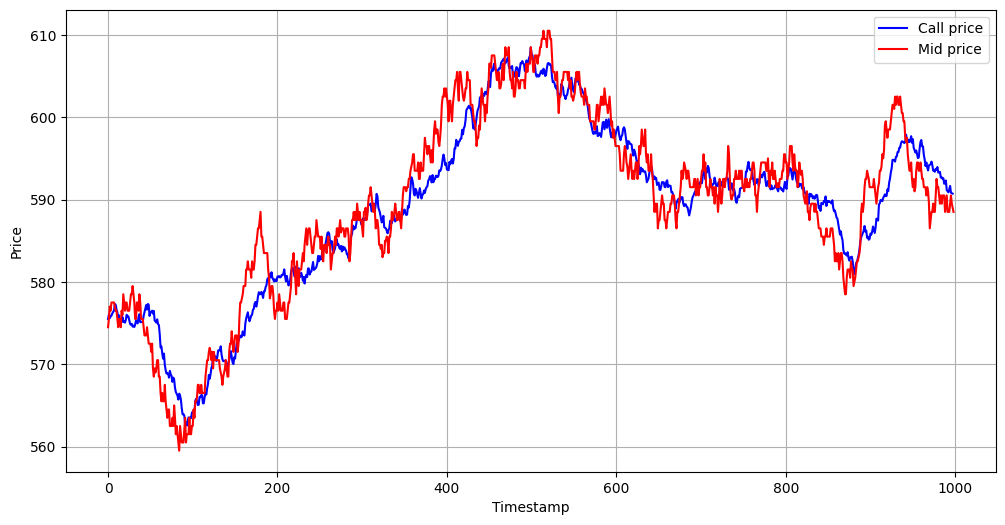

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(call_prices[:], marker='', linestyle='-', color='b', label="Call price")
plt.plot(data["COCONUT_COUPON"]["mid_price"].values[:], marker='', linestyle='-', color='r', label="Mid price")
plt.xlabel("Timestamp")
plt.ylabel("Price"),
plt.legend()
plt.grid(True)
plt.show()